##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from multiprocessing import Pool
from functools import partial
from sklearn import metrics

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
# from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats

from ipywidgets import FloatProgress, HTML
from IPython.display import display, clear_output
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

import json
import os




     



def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['PPFD_Avg','AirTC_Avg','VPD','wind_speed',
                    'Temp','VWC','Sedge','Shrub','Grass','Upland',
                    'HR','DOY']
        if Scope == 'Test':
            Model = ['PPFD_Avg','VPD','wind_speed','VWC']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model=['AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg','Table_1','Delta_Table_1','VWC_1','VWC_2',#'Delta_VWC_1','Delta_VWC_2',
                   'Temp_2_5_1','Temp_5_1','Temp_15_1','Active_Layer_1',
                   'u*','wind_speed','air_pressure','Delta_air_pressure','Wind_Direction']#,'air_pressure','Delta_air_pressure']
#             Model=['AirTemp','Rainfall_Tot','SoilMoist(4)','SoilMoist(5)','Net_SW_Wm2_Avg',
#                    'Net_LW_Wm2_Avg','Net_Ttl_Rad_Avg','WindSpd','Delta_SoilMoist(4)','Delta_SoilMoist(5)']
        if Scope == 'Test':
#             Model=['AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg','Table_1','Delta_Table_1',
#                    'VWC_2','Delta_VWC_2','Temp_2_5_1','Temp_5_1','Temp_15_1','Active_Layer_1',
#                    'u*','wind_speed']
            Model = ['AirTC_Avg','u*','NR_Wm2_Avg','Temp_15_1','air_pressure','wind_speed','Active_Layer_1']
#                    'VWC_2','Delta_VWC_2','Temp_2_5_1','Temp_5_1','Temp_15_1','Active_Layer_1',
#                    'u*','wind_speed'']
#             Model=['AirTemp','Rainfall_Tot','SoilMoist(4)','SoilMoist(5)','Net_SW_Wm2_Avg',
#                    'Net_LW_Wm2_Avg','Net_Ttl_Rad_Avg','WindSpd','Delta_SoilMoist(4)','Delta_SoilMoist(5)']
    return(Model)

def Stats(mse,se,r2,j,params,i=0):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],'MSE':[mse],'Size':j,'Number':i,'HiddenNodes':params['N'],
                            'SE':[se],'r2':[r2],'Performance':0,'K':[params['K']]})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))
MP = False
MP = True
Scope = 'Full'
# Scope = 'Test'
if MP == True:
    processes = 3
else:
    processes = 1
# memory = .95/processes
    
cwd = os.getcwd()
Site='FishIsland'
# Site = 'Illisarvik'
alpha = .05

pd.set_option('max_colwidth',200)
def Display (tar,prog1=None,prog2=None,MdLs=None,MdL=None):
    clear_output()
    display(tar)
    if prog1!=None:
        display(prog1)
    if prog2!=None:
        display(prog2)
    if MdLs!=None:
        display(MdLs)
    if MdL!=None:
        display(MdL)
    
tar = HTML(
            value=" ",
            placeholder='Target: ',
            description='Target: ',
        )
kwt = HTML(
        value=str(0),
        placeholder='Quit Score: ',
        description='Quit Score: ',
        )


Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'   
# try:
#     shutil.rmtree(Path)
# except:
#     pass
# try:
#     os.mkdir(Path+'/')
# except:
#     pass
# print(Path)

Using TensorFlow backend.


# Model

In [2]:
def RecWrite(AllRes,Path):
    for f in AllRes.keys():
        try:
            os.mkdir(Path)
        except:
            pass
        for t in AllRes[f].keys():
            if t != 'Results' and t != 'Records':
                for p in AllRes[f][t].keys():
                    np.save(Path+f+'_'+t+'_'+str(p)+'.npy',AllRes[f][t][p])
        AllRes[f]['Records'].to_csv(Path+f+'_Runs.csv')
        AllRes[f]['Results'].to_csv(Path+f+'_Results.csv')
        
def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:
        AllRes[f]={}
        AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
        AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
        AllRes[f]['Derivatives']={}
        AllRes[f]['SSQ'] ={}
        AllRes[f]['X'] = {}
        AllRes[f]['Yhat'] = {}
        AllRes[f]['Ytrue'] = {}
        AllRes[f]['Outputs'] = {}

        for filename in os.listdir(Path):
            if filename.endswith(".npy") and filename.split('.')[0].split('_')[0]==f:
                AllRes[f][filename.split('.')[0].split('_')[1]][int(filename.split('.')[0].split('_')[-1])]=\
                np.load(Path+filename)
    return(AllRes)


In [3]:
# depth = 15
Time = time.time()
AllRes={}
if __name__ == '__main__':
    try:
        shutil.rmtree(Path+'/'+target+'/')
        os.mkdir(Path+'/')
    except:pass
    for target in ['fch4','fco2']:
        AllRes[target]={}
        AllRes[target]['Results'] = {}
        AllRes[target]['Derivatives'] = {}
        AllRes[target]['SSQ'] ={}
        AllRes[target]['X'] = {}
        AllRes[target]['Yhat'] = {}
        AllRes[target]['Ytrue'] = {}
        AllRes[target]['Outputs'] = {}
        AllRes[target]['Removed']=[]
#         AllRes[target]['Factors'] = []
        Rm = []
        Input=ModSelect(Scope,Site)
        start = len(Input)
        IpKey=np.arange(0,start)
        IpDict={'Factors':Input.copy(),'Key':IpKey}
        try:
#             shutil.rmtree(Path+'/'+target+'/')
            os.mkdir(Path+'/'+target+'/')  
        except:pass
        tar.value=target
        prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
        MdL = HTML(value=" ",placeholder='Testing: ',description='Testing: ')
        Display (tar,prog2=prog2,MdL=MdL)
        Continue = True
        first = 1
        num = 0
#         for Input in Models:
        while len(Input) > 0:
            if num >0:
                print(Rm)
#         while num <2:
            Time2 = time.time()
            j = len(Input)
            params = Dense.Params(Scope,target,MP=MP)
            params['Dpath'] = cwd+'/'+Site+'/'
            params['Spath'] = Path+target+'/'+str(j)+'_'+str(num)+'/'
            try:os.mkdir(params['Spath'])
            except:pass
            params['Sname'] = 'Y_'
            params['Inputs'] = Input
            MdL.value='N = '+str(j)+':  '+str(params['Inputs'])
            Display (tar,prog2=prog2,MdL=MdL)
            print('Inputs!: ', params['Inputs'])
            print('Total Runtime: ',time.time()-Time)
            print('Training Time: ', time.time()-Time2)
            params['Model'] = '+'.join(params['Inputs'])
            RST = RSTF.ReadStandardTimeFill(params,'AllData.csv')#,resample='2H')
#             RST = RSTF.ReadStandardTimeFill(params,'TagluData.csv')#,resample='2H')
            if target == 'ER':
                RST.Master = RST.Master.loc[RST.Master['fco2']>0]
            RST.Scale(params['target'],params['Inputs']) 
            y = RST.y*1.0
            X = RST.X*1.0
#             print(X,y)
            Ni = len(Input)
            Ns = y.shape[0]
            No = 1
            a = 2
            params['N']=int(Ns/(a*(Ni+No)))
#             Rule by Maier et al. 1998
#             A = int(a*Ni+No)
#             B = int(a*Ns/((Ni+No)))
#             if A<B:params['N']=A
#             else:params['N']=B
                
            params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
            Y_hat=[]
            y_true=[]
            X_true=[]
            index=[]
            ones=[]
            prog2.value=0
            Avs = []
            Derivatives = []
            Outputs=[]
            if MP == False:
                for k in range(params['K']):
                    results = Dense.Bootstrap(k,params=params,X=X,y=y)
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    ones.append(results[3])
                    prog2.value=(k+1)/params['K']*100
                    Avs.append(results[4])
                    Derivatives.append(results[5])
                    Outputs = results[6]
            else:
                pool = Pool(processes=processes,maxtasksperchild=75)
                for k,results in enumerate(pool.imap_unordered(partial(Dense.Bootstrap,params=params,X=X,y=y),range(params['K']))):
#                     print(k)
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    ones.append(results[3])
                    prog2.value=(k+1)/params['K']*100
                    Avs.append(results[4])
                    Derivatives.append(results[5])
                    Outputs.append(results[6])
                pool.close()
            Y_hat = np.squeeze(np.asanyarray(Y_hat))
            y_true = np.squeeze(np.asanyarray(y_true))
            X_true = np.asanyarray(X_true)
            ones = np.asanyarray(ones)
            params['Memory'] = .95
            results = Dense.Sort_outputs(0,params=params,Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones)
            mse,se,r2 = results
            Level = Stats(mse,se,r2,j,params,i=num)
            Level.to_csv('Temp.csv')
#             prog1.value=start-j#+i/len(Inputs)
            Level['Thresh'] = Level['MSE']+Level['SE']
            Min = Level.loc[Level['MSE']==Level['MSE'].min()]
            if first == 1:
                Records = Level
            else:
                Records = Records.append(Level)
            Av = np.array(Avs).mean(axis=0)
            Drv = np.array(Derivatives)#.mean(axis=0)
            Av = (Drv.mean(axis=0)**2).sum(axis=1)
            Range = Drv.mean(axis=0).max(axis=1)-Drv.mean(axis=0).min(axis=1)
            SE = (np.array(Avs).T/np.array(Avs).sum(axis=1)).T
            SE = SE.std(axis=0)**.5/(params['K']**.5)
            if first==2:
                IpDict['RC: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])
                IpDict['RG: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
                IpDict['SE: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
#                 IpDict['Sum'+str(j)+'_'+ str(num)]=np.zeros(Results.shape[0])
            else:
                first = 2
            Results = pd.DataFrame(data=IpDict)
            for I,A,S,R in zip(Input,Av,SE,Range):
                Results.loc[Results['Factors']==I,'RC: '+str(j)+'_'+ str(num)]=A
                Results.loc[Results['Factors']==I,'RG: '+str(j)+'_'+ str(num)]=R
                Results.loc[Results['Factors']==I,'SE: '+str(j)+'_'+ str(num)]=S
            Results['RC: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)]/Results['RC: '+str(j)+'_'+ str(num)].sum()
#             Results['RG: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)].max()-Results['RC: '+str(j)+'_'+ str(num)].min()

#             print(Results)
            Temp = Results.copy()
            Temp['Sum'+str(j)+'_'+ str(num)]=Temp['RC: '+str(j)+'_'+ str(num)]-Temp['SE: '+str(j)+'_'+ str(num)]
#             Scores = Results.sort_values(by='RG: '+str(j)+'_'+ str(num)).reset_index(drop = True).
            Scores = Temp.sort_values(by='RC: '+str(j)+'_'+ str(num)).reset_index().reset_index()
#             Scores['level_0']*=1.001
#             Scores['Sum'+str(j)+'_'+ str(num)] = (Scores[['level_0','index']].sum(axis=1))
#             print(Scores)
            Scores.loc[Scores['Sum'+str(j)+'_'+ str(num)]<=0,'Sum'+str(j)+'_'+ str(num)]=0
            if num >0:
                Scores['Sum'+str(j)+'_'+ str(num)]+=Scores['Sum'+str(j+1)+'_'+ str(num-1)]

            Results = Results.join(Scores.set_index('Key')[['Sum'+str(j)+'_'+ str(num)]],on='Key')
            
            IpDict['RC: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)].values
            IpDict['RG: '+str(j)+'_'+ str(num)]=Results['RG: '+str(j)+'_'+ str(num)].values
            IpDict['SE: '+str(j)+'_'+ str(num)]=Results['SE: '+str(j)+'_'+ str(num)].values
            IpDict['Sum'+str(j)+'_'+ str(num)]=Results['Sum'+str(j)+'_'+ str(num)].values
#             print(Results)
            
            Results = Results.sort_values('Sum'+str(j)+'_'+ str(num))
            Resluts = Results.reset_index()
            

            
#             print(Rm)
            Rm.append(Results.Factors.values[num])
#             print('Resutl')
#             print(Results)
            print(Rm,Results.Factors.values,num)
            
#             aaaaaa = input('Continue')
            
                
            Input.remove(Rm[-1])
            Results = Results.sort_values('Key')
            Min = Records.loc[Records['MSE']==Records['MSE'].min()]
#             if Min['MSE'].values[0]+Min['SE'].values[0]*2<=Level['MSE'].values[0]:
#             if len(Input) == 0:
#                 Continue = False
            AllRes[target]['Records']=Records
            AllRes[target]['Results'] = Results
            AllRes[target]['Derivatives'][j]=Drv
            AllRes[target]['SSQ'][j]=Avs
            AllRes[target]['X'][j] = X_true[0]
            AllRes[target]['Outputs'][j] = Outputs
            AllRes[target]['Yhat'][j] = Y_hat
            AllRes[target]['Ytrue'][j] = y_true
#             AllRes[target]['Factors'].append(j)
            AllRes[target]['Removed']=Rm
            num +=1
#             with open(target+'dict.txt','w') as file:
#                 file.write(json.dumps(AllRes))
#             j+=1

RecWrite(AllRes,Path)

HTML(value='fco2', description='Target: ', placeholder='Target: ')

FloatProgress(value=100.0, description='Bootstrapping:')

HTML(value="N = 1:  ['PPFD_Avg']", description='Testing: ', placeholder='Testing: ')

Inputs!:  ['PPFD_Avg']
Total Runtime:  4642.96270942688
Training Time:  0.006506204605102539
['AirTC_Avg', 'air_pressure', 'wind_speed', 'u*', 'Temp_15_1', 'Delta_air_pressure', 'Wind_Direction', 'Table_1', 'VWC_1', 'Delta_Table_1', 'VPD', 'Temp_5_1', 'VWC_2', 'Temp_2_5_1', 'NR_Wm2_Avg', 'Active_Layer_1', 'PPFD_Avg'] ['AirTC_Avg' 'air_pressure' 'wind_speed' 'u*' 'Temp_15_1'
 'Delta_air_pressure' 'Wind_Direction' 'Table_1' 'VWC_1' 'Delta_Table_1'
 'VPD' 'Temp_5_1' 'VWC_2' 'Temp_2_5_1' 'NR_Wm2_Avg' 'Active_Layer_1'
 'PPFD_Avg'] 16


<IPython.core.display.Javascript object>


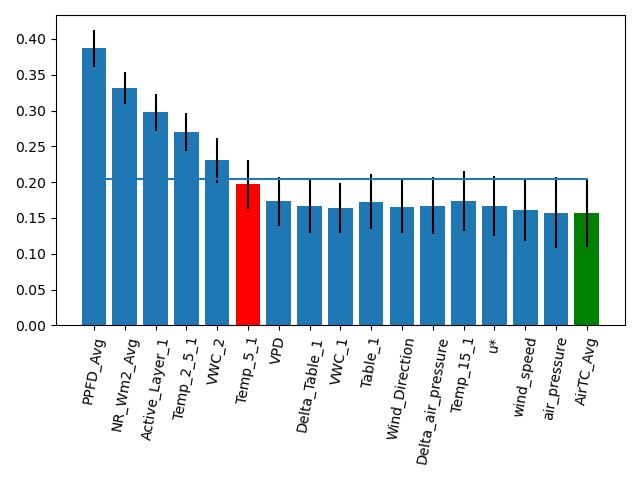

dict_keys([1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 2, 3, 4, 5, 6, 7, 8, 9])


<IPython.core.display.Javascript object>


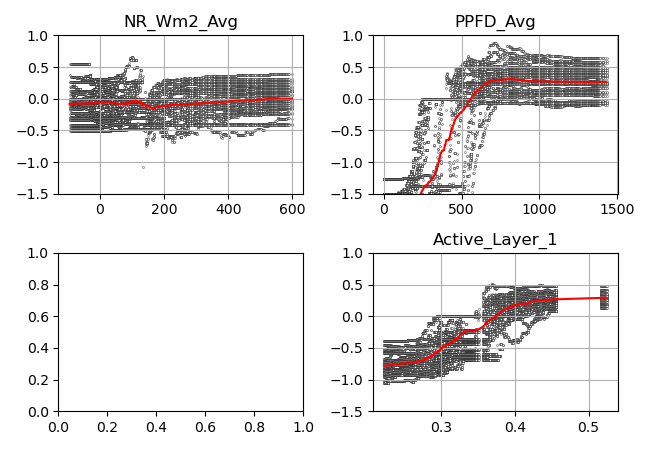

               Factors  RC: 3_14  SE: 3_14    Sum3_14
0            AirTC_Avg  0.000000  0.000000   0.000000
1                  VPD  0.000000  0.000000   0.028580
2           NR_Wm2_Avg  0.002327  0.027357   0.242867
3             PPFD_Avg  0.905069  0.041565  10.215213
4              Table_1  0.000000  0.000000   0.000000
5        Delta_Table_1  0.000000  0.000000   0.005253
6                VWC_1  0.000000  0.000000   0.000513
7                VWC_2  0.000000  0.000000   0.088538
8           Temp_2_5_1  0.000000  0.000000   0.101813
9             Temp_5_1  0.000000  0.000000   0.054797
10           Temp_15_1  0.000000  0.000000   0.000000
11      Active_Layer_1  0.092603  0.037922   0.425646
12                  u*  0.000000  0.000000   0.000000
13          wind_speed  0.000000  0.000000   0.000000
14        air_pressure  0.000000  0.000000   0.000000
15  Delta_air_pressure  0.000000  0.000000   0.000000
16      Wind_Direction  0.000000  0.000000   0.000000
0     0.000000
1     0.00000

In [16]:
F = 'fco2'
AllRes = RecRead(Path)
# Results = AllRes[F].keys()
Results = AllRes[F]['Results']
try:
    Results = Results.drop(columns='Key')
except:
    pass
Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values


AllRes[F]['Records']['RMSE']=(AllRes[F]['Records']['MSE']**.5)
Records = AllRes[F]['Records']
# print(Records)

plt.figure()
Min = Records.loc[Records['MSE']==Records['MSE'].min()]
Best = Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*1]
Best = Best.loc[Best['Size']==Best['Size'].min()]
plt.bar(Records['Size'],Records['MSE'],yerr=Records['SE'])
plt.bar(Best['Size'],Best['MSE'],yerr=Best['SE'],color='r')
plt.bar(Min['Size'],Min['MSE'],yerr=Min['SE'],color='g')
plt.xticks(Records['Size'],Labels,rotation=80)
line = [Min['MSE'].values[0]+Min['SE'].values[0],Min['MSE'].values[0]+Min['SE'].values[0]]
plt.plot([Records['Size'].min(),Records['Size'].max()],line)
# print(Best)
plt.tight_layout()
N_best = Best.Size.values[0]

N = N_best
N=3
print(AllRes[F]['Derivatives'].keys())
Derivatives = AllRes[F]['Derivatives'][N]
# print(Derivatives.shape)
Mean = Derivatives.mean(axis=0)
X = AllRes[F]['X'][N]
# if
if N>2:
    fig,ax = plt.subplots(int((N+1)/2),2,figsize = (6.5,N*1.5))
else:
    fig,ax = plt.subplots(2,2,figsize = (6.5,4*1.5))
k = 0
j=0
TD = []
i = 0
mx,mn=-1,1
PD = {}
# plot = 'Table_1'
# a
m = -.495
# print(Results)

a = 'RC: '+Records.loc[Records['Size']==N].index.values[0]
ase = 'SE: '+Records.loc[Records['Size']==N].index.values[0]
print(Results[['Factors',a,ase,'Sum3_14']])
print(Results['RC: '+str(3)+'_'+ str(14)]-Results['SE: '+str(3)+'_'+ str(14)])


print(Rm)
for f,r in zip(Results.Factors.values,Results[a].values):
#     print()
#     print(f,r)
    if r > 0:
#         if f == plot:
        if i >N/2-1:
            j=1
            k = (math.floor(N/2))
        for p in range(Derivatives.shape[0]):
#             print(p,i)
#             print(Derivatives[p][i].shape)
            Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Derivatives[p][i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
            Temp = Temp.sort_values(by='X')
            ax[i-k,j].scatter(Temp['X'],Temp['Y'],c='white',s=2,edgecolor='k',linewidth=.25)
#             ax[i].scatter(Temp['X'],Temp['Y'],c='k',s=2)
#             ax.scatter(Temp['X'],Temp['Y'],c='k',s=2)
            if Derivatives[p][i].max()>mx:
                mx=Derivatives[p][i].max()
            if Derivatives[p][i].min()<mn:
                mn=Derivatives[p][i].min()
#         print(Mean[i].shape)
        Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
        Temp = Temp.sort_values(by='X')

        ax[i-k,j].plot(Temp['X'],Temp['Y'],color='r')#.scatter(X[:,i],Mean[i],color='k',s=10)
        ax[i-k,j].set_title(f)
        ax[i-k,j].grid()
        ax[i-k,j].set_ylim(-1.5,1)
#         ax[i].plot(Temp['X'],Temp['Y'],color='r')#.scatter(X[:,i],Mean[i],color='k',s=10)
#         ax[i].set_title(f)
#         ax[i].grid()
#         ax.plot(Temp['X'],Temp['Y'],color='r')#.scatter(X[:,i],Mean[i],color='k',s=10)
#         ax.set_title(f)
#         ax.grid()

        TD.append([f,Mean[i].min(),Mean[i].max(),Mean[i].mean(),Mean[i].max()-Mean[i].min(),(Mean[i]**2).sum()])
        i +=1
# print(mn,mx)
# plt.setp(ax, ylim=[mn-m,mx-m])
plt.tight_layout()
Statistics = pd.DataFrame(data=TD,columns=['Factor','Min','Max','Mean','Range','SSQ'])

# print(Statistics.sort_values('Range'))
plt.savefig(F+'Derivs.png')

<IPython.core.display.Javascript object>


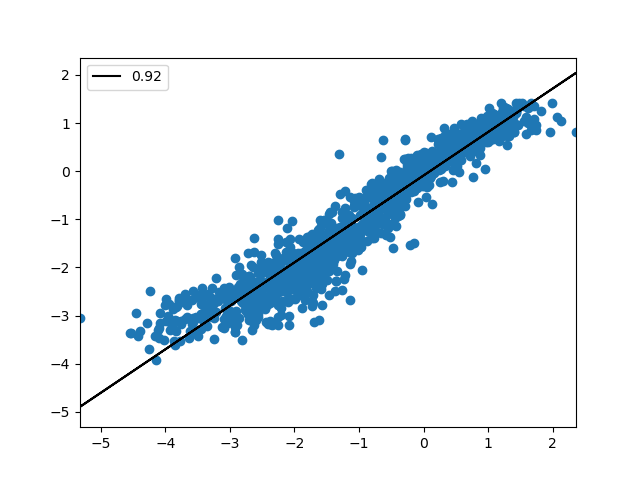

(-5.320636065653571, 2.36125375861765)

In [7]:
plt.figure()
# nm=6
y,x = AllRes[F]['Yhat'][N].mean(axis=0),AllRes[F]['Ytrue'][N].mean(axis=0)
slope,intercept,r,p,SE = stats.linregress(x,y)
# print(Op)
plt.scatter(x,y)#(AllRes['fch4'].keys())
plt.plot(x,intercept+slope*x,label=str(np.round(r**2,2)),color='k')
plt.legend()
plt.xlim(x.min(),x.max())
plt.ylim(x.min(),x.max())



0    0.003129
1    0.020792
2    0.033437
3    0.040751
4    0.065839
5    0.836052
Name: RC: 6_11, dtype: float64


<IPython.core.display.Javascript object>


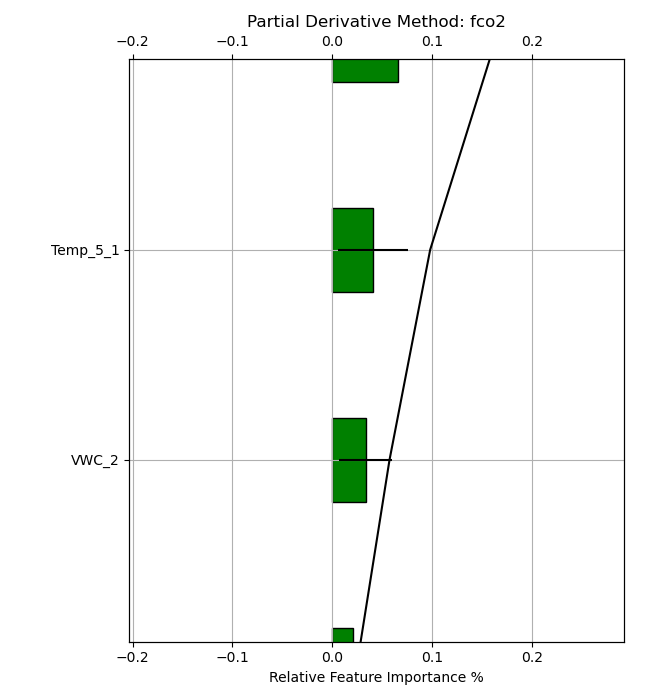

<IPython.core.display.Javascript object>


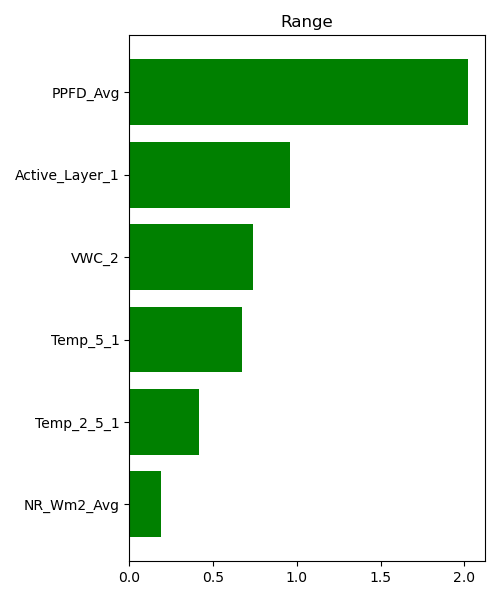

In [8]:

# print(Records)
b = '15_0'
# a = '7_8'
try:
    Results = Results.loc[Results[a]>0].sort_values(a,ascending=True).reset_index()
except:
    pass

# print(a)
# print(Results[a],Results['RC: '+b],)
# print(Results.Factors.values[1:])
print(Results[a])
fig,ax=plt.subplots(figsize=(6.5,7))
ax.barh(Results.index,Results[a],xerr=Results[ase],
         height=.4,color='g',edgecolor='k')
# ax.barh(Results.index+.45,Results['RC: '+b],xerr=Results['SE: '+b],
#          height=.4,color='r',edgecolor='k')
ax2=ax.twiny()
ax2.plot(Results[a].cumsum(),Results.index,color='k')
# plt.barh(Results.index+.5,Results['RC: '+Min],xerr=Results['SE: '+Min],height=.5,color='r')
ax.set_yticks(Results.index)
ax.set_yticklabels(Results['Factors'].values)
# plt.xticks(rotation=90)

ax.set_xlabel('Relative Feature Importance %')
ax.set_title('Partial Derivative Method: '+F)
ax.grid()
ax.set_xlim(0,1)
ax2.set_xlim(0,1)
plt.tight_layout()
# plt.show()

plt.savefig('PAD_'+F+'_PrunedFactors.png')
# print(Results.shape[0])

Statistics['Abs']=np.abs(Statistics.Mean)
Statistics['SSQ%']=Statistics['SSQ']/Statistics['SSQ'].sum()
# print(Statistics.sort_values('Range'))
# try:
Statistics = Statistics.sort_values('Range').reset_index(drop=True)
# except:
#     pass
    
fig,ax=plt.subplots(figsize=(5,6))
ax.barh(Statistics.index,Statistics['Range'],
         color='g')
ax.set_yticks(Statistics.index)
ax.set_yticklabels(Statistics['Factor'].values)
ax.set_title('Range')
plt.tight_layout()
